## Hello! 

We have created a diffusion model to mimic the monthly averaged PS, T2m and Precipitation from the CESM-LENS2 data!! 

Here is information on the [CESM2 Large Ensemble](https://www.cesm.ucar.edu/community-projects/lens2). This is a 50 member climate ensemble (lots of compute), that we can now expand to have infinite fields which learn it's prior distribution and determine a postirior conditioned on month and co2 concentration

This repository adapts the [Denoising Diffusion Probabilistic Model](https://arxiv.org/abs/2006.11239) for climate predictions using the CESM2 Large Ensemble (LENS) data. It predicts T2m, Precipitation, and Surface Pressure, conditioned on a given month and CO2 concentration (CO2vmr). This enables climate model forecasts with diffusion-based predictions, improving upon existing methodologies for ensemble predictions.
- The information and code for how I have done this is contained here [https://github.com/WillyChap/denoising-diffusion-pytorch/tree/CESM_Clean]
  - I am more than happy to get into the nuts & bolts if you would like, please ask!


### GOAL of project 🐴
**The goal of this project group is the outline the utility of this emulator.** What I have done is made 500 new ensemble members for every month (JJA and DJF) at every CO2 concentration! A wealth of data! 

Now it is our job to come up with some purpose for this data. Here are some of my ideas:

- does the emulator represent the warming trend well?
- what is the minimum baseline for this to be useful?
  - do we need any post-processing? 
- Does this system represent internal variability well (i.e. the ENSO teleconnection)?
  - what does this say about the change in the ENSO connection?
- Is internal variability changing? -- I see a narrowing on the Feb internal variability.
- Can we increase our understanding of climate change emergence signals?
- What can we learn about extreme events?
- Where are the structural biases / differences? 

If you would like to know more about diffusion modeling, I highly recommend that you take this course!: 
- https://www.youtube.com/watch?v=8mxCNMJ7dHM&list=PL0H3pMD88m8XPBlWoWGyal45MtnwKLSkQ

For a primer on general machine learning watch this: 
- https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

I have placed a few papers here which assess emergence and extremes, feel free to add to this library! 📚
- https://drive.google.com/drive/folders/1MAK1BRPGJSSQaQnEy0atlhI4kWq_510T?usp=drive_link

In [3]:
import xarray as xr 
import os 
import numpy as np 
import sys 
import matplotlib.pyplot as plt 
import glob
import pickle
import xskillscore as xs
from eofs.xarray import Eof

import os
import cartopy.crs as ccrs

import numpy as np
import xarray as xr
import os
from sklearn.preprocessing import QuantileTransformer
from functools import lru_cache

import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count

from scipy.optimize import linear_sum_assignment

from PIL import Image
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

ERROR 1: PROJ: proj_create_from_database: Open of /users_home/training/u01/.conda/envs/diff-analysis-2024b/share/proj failed


## File Structure 

The Files are arranged by Month and CO2 value (PPM), SAMPLES are the ensemble members:

In [2]:
data_path = '/users_home/training/data/Group_01/Ensembles/'
file_name = 'samples_governance_indexes_3944_month02_co20.0003991389897498876_001.nc'

fp = f'{data_path}/{file_name}'
DS = xr.open_dataset(fp)
DS

<xarray.Dataset> Size: 332MB
Dimensions:  (samples: 500, lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon      (lon) float64 2kB 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * samples  (samples) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    PS       (samples, lat, lon) float32 111MB ...
    PRECT    (samples, lat, lon) float32 111MB ...
    TREFHT   (samples, lat, lon) float32 111MB ...

## Useful Functions I have written for you

In [7]:
def plot_ENSO_NA(slopes_diffy):
    levels = list(np.arange(-.7, .75, .05) * 1e-8)
    cmap = plt.get_cmap('RdBu_r')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    
    # Define fewer ticks for the colorbar
    fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    # Set extent to zoom in on a particular region
    ax.set_extent([120, 300, 10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]
    
    # Color-filled plot for TREFHT with discrete levels
    prect_plot = slopes_diffy['PRECT'].plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap=cmap, 
        norm=norm, 
        add_colorbar=True, 
        cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
    )
    plt.title('Regional Zoom: TREFHT (color) and PS (contours)')
    
    # Adding contour lines for PS
    contour = ax.contour(slopes_diffy['PS']['lon'], slopes_diffy['PS']['lat'], slopes_diffy['PS'], levels=10, colors='black', transform=ccrs.PlateCarree())
    ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
    
    # Adding coastlines and formatting
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))
    
    plt.tight_layout()
    plt.show()

def plot_ENSO_NA_diff(slopes_diffy1, slopes_diffy2):
    levels = list(np.arange(-.7, .75, .05) * 1e-8)
    cmap = plt.get_cmap('RdBu_r')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    
    # Define fewer ticks for the colorbar
    fewer_ticks = [-7e-9, -5e-9, -3e-9, -1e-9, 1e-9, 3e-9, 5e-9, 7e-9]  # Select fewer representative levels
    
    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    
    # Set extent to zoom in on a particular region
    # ax.set_extent([120, 300, -10, 80], crs=ccrs.PlateCarree())  # [min_lon, max_lon, min_lat, max_lat]
    
    # Color-filled plot for TREFHT with discrete levels
    prect_plot = (slopes_diffy1['PRECT']-slopes_diffy2['PRECT']).plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap=cmap, 
        norm=norm, 
        add_colorbar=True, 
        cbar_kwargs={'boundaries': levels, 'ticks': fewer_ticks, 'shrink': 0.7}  # Shrink and reduce the number of ticks
    )
    plt.title('Regional Zoom: PRECT (color) and PS (contours)')
    
    # Adding contour lines for PS
    contour = ax.contour(slopes_diffy1['PS']['lon'], slopes_diffy1['PS']['lat'], slopes_diffy1['PS']-slopes_diffy2['PS'], levels=10, colors='black', transform=ccrs.PlateCarree())
    ax.clabel(contour, inline=True, fontsize=8, fmt='%1.0f')
    
    # Adding coastlines and formatting
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.set_xticks([120, 150, 180, 210, 240], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.set_yticks([10, 20, 30, 40, 50, 60], crs=ccrs.PlateCarree())  # Adjusted for the zoomed region
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°'))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°'))
    
    plt.tight_layout()
    plt.show()
    
def compute_regression_slopes(DS, vardo='TREFHT', region_lat=(-5, 5), region_lon=(190, 240)):
    """
    Compute the regression slopes of each variable (PS, PRECT, TREFHT) with respect to the mean of TREFHT
    over a specified region.

    Parameters:
    DS (xarray.Dataset): The dataset containing the variables.
    region_lat (tuple): Latitude bounds for selecting the region (default: (-5, 5)).
    region_lon (tuple): Longitude bounds for selecting the region (default: (190, 240)).

    Returns:
    dict: A dictionary containing the slope datasets for each variable (PS, PRECT, TREFHT).
    """
    
    # Step 1: Select the mean of TREFHT over the specified region
    trefht_mean = DS[vardo].sel(lat=slice(*region_lat), lon=slice(*region_lon)).mean(dim=['lat', 'lon'])
    
    # Step 2: Demean the independent variable (TREFHT)
    trefht_mean_demeaned = trefht_mean - trefht_mean.mean(dim='samples')
    
    # Step 3: Loop over each variable and compute the slope at each (lat, lon) point
    regression_slopes = {}
    for var_name in ['PS', 'PRECT', 'TREFHT']:
        # Demean the dependent variable at each (lat, lon) point
        y = DS[var_name]
        y_demeaned = y - y.mean(dim='samples')
        
        # Compute the slope (cov(y, x) / var(x)) at each (lat, lon) point
        slope = (y_demeaned * trefht_mean_demeaned).mean(dim='samples') / (trefht_mean_demeaned ** 2).mean(dim='samples')
        
        # Store the slope result for this variable
        regression_slopes[var_name] = slope
    
    return regression_slopes


def closest_co2vmr_year(co2vmr, FNS):

    closest_diff = np.inf  # Initialize with a large value
    closest_time = None
    closest_file = None
    
    # Dictionary to store the time data from each file
    dict_times = {}

    for fn in FNS:
        # Open the dataset once per file
        CESM_LE = xr.open_dataset(fn)
        timers = CESM_LE['time'].values
        co2vmr_values = CESM_LE['co2vmr'].values

        # Store the time information in a dictionary for later retrieval
        dict_times[fn] = timers

        # Calculate the absolute difference for the CO₂ VMR values in this file
        abs_diff = np.abs(co2vmr_values - co2vmr)

        # Find the index of the minimum difference in this file
        min_index = np.argmin(abs_diff)

        # Update if the current file has a closer CO₂ VMR value
        if abs_diff[min_index] < closest_diff:
            closest_diff = abs_diff[min_index]
            closest_time = timers[min_index]
            closest_file = fn
            print('min dist:', abs_diff[min_index])

    # Return the year, month, and file name of the closest match
    return closest_time.year, closest_time.month, closest_file

def extract_closest_co2vmr_data(co2vmr, mt, var, FNS):
    """
    Extract data for the given variable where CO₂ VMR is closest to the target value for each file.
    
    Parameters:
    - co2vmr: The target CO₂ VMR value (float).
    - var: The variable name to extract (str).
    - FNS: List of file paths to NetCDF datasets (list of strings).
    
    Returns:
    - xarray.DataArray: DataArray containing the stacked data across all files, with dimensions 'time', 'lat', and 'lon'.
    """
    dats_list = []
    
    for fn in FNS:
        # Open the dataset
        CESM_LE = xr.open_dataset(fn)
        
        # Select March data (since CESM files are 1 month forward, we're using month == 3)
        feb_data = CESM_LE.where(CESM_LE['time.month'] == mt, drop=True)
        
        # Get the CO2 VMR values
        co2vmr_values = feb_data['co2vmr'].values
        
        # Calculate the absolute difference between the current CO₂ VMR values and the target
        abs_diff = np.abs(co2vmr_values - co2vmr)
        
        # Find the index of the minimum difference
        closest_index = np.argmin(abs_diff)
        
        # Extract the corresponding data point for the given variable at the closest CO₂ VMR
        dats_do = feb_data.isel(time=closest_index)[var].values
        
        # Append this data to the list
        dats_list.append(dats_do)
    
    # Stack the list of data arrays into a new dimension ('time')
    dats_stack = np.stack(dats_list, axis=0)
    
    # Get lat, lon, and time coordinates (assuming they are consistent across all files)
    lat = feb_data['lat'].values
    lon = feb_data['lon'].values
    times = np.arange(len(FNS))  # A new "time" dimension, you could modify this if actual time is needed.
    
    # Create an xarray DataArray from the stacked data
    dats_da = xr.DataArray(dats_stack, dims=['time', 'lat', 'lon'], coords={'time': times, 'lat': lat, 'lon': lon})
    
    return dats_da.to_dataset(name=var)


def concat_files_by_month(month_get, file_pattern):
    """
    Concatenate datasets along a 'samples' dimension, selecting data from a specific month.

    Parameters:
    month_get (int): The month to filter by (e.g., 2 for February).
    file_pattern (str): The glob pattern for the input NetCDF files.

    Returns:
    xarray.Dataset: Concatenated dataset along the 'samples' dimension.
    """
    # Step 1: Get the list of files
    FNS = sorted(glob.glob(file_pattern))

    # Step 2: Create an empty list to hold the filtered datasets
    datasets = []

    # Track the running count of samples
    sample_counter = 0

    # Step 3: Loop over each file and load the dataset, selecting only data for the given month
    for fps in FNS:
        # Open the dataset
        # print(fps)
        DS = xr.open_dataset(fps)

        # Select only data from the specified month
        mo_g = month_get+1

        if mo_g == 13:
            mo_g = 1
        
        DS_feb = DS.sel(time=DS['time.month'] == mo_g)

        # Determine the number of time steps in the current dataset
        n_samples = DS_feb.sizes['time']

        # Replace the 'time' dimension with 'samples' and increment the sample index
        DS_feb = DS_feb.rename({'time': 'samples'})  # Rename 'time' to 'samples'

        # Assign a new 'samples' coordinate, starting from the running sample counter
        DS_feb = DS_feb.assign_coords(samples=(sample_counter + np.arange(n_samples)))

        # Update the sample counter for the next dataset
        sample_counter += n_samples

        # Append the modified dataset to the list
        datasets.append(DS_feb)

    # Step 4: Concatenate along the new "samples" dimension
    DS_concat = xr.concat(datasets, dim='samples')

    return DS_concat

## Lets look at comparison to the global warming trend signal for February!: 

- the LENS data is made here: /glade/derecho/scratch/wchapman/CESM_LE2_vars_BSSP370cmip6/

In [32]:
FNS = sorted(glob.glob(f'//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month{momo:02}*.nc'))
FNS

['//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.0003991389897498876_001.nc',
 '//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.0004020489956418128_001.nc',
 '//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.0004049043903089039_001.nc',
 '//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.00040781448757888313_001.nc',
 '//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.0004108964775733599_001.nc',
 '//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.00041407351246524655_001.nc',
 '//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.0004173469214623615_001.nc',
 '//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.00042070317072538687_001.nc',
 '//users_home/traini

In [33]:
%%time

#this gets all the file paths: 
momo = 1 #month! 
FNS = sorted(glob.glob(f'//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month{momo:02}*.nc'))

mea_trend = []
std_trend = []
all_mea_trend ={}

lens_mea_trend = []
lens_std_trend = []
all_lens_mea_trend ={}


for ee,fn in enumerate(FNS):
    print('doing:',ee+2015,fn)
    DS = xr.open_dataset(fn)
    lat = DS['lat']
    # Calculate weights: cos(lat) in radians
    weights = np.cos(np.deg2rad(lat))

    tmean = DS['TREFHT'].weighted(weights).mean(dim=['lat', 'lon','samples'])
    mea_trend.append(tmean.values)

    all_mea_trend[ee] = DS['TREFHT'].weighted(weights).mean(dim=['lat', 'lon']).values

    # DDS = xs.resample_iterations_idx(DS['TREFHT'], 50, "samples") 
    # std_trend.append(DDS.sel(samples=slice(0,50)).weighted(weights).mean(dim=['samples','lat','lon']).std('iteration'))

    #now for the LENS:
    #1. find files:
    co2vmr = float(fn.split('co2')[-1].split('_')[0])
    FNS = sorted(glob.glob('/users_home/training/data/Group_01/LENS/*1001.001*.nc'))
    yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)

    if mt != (momo+1):
        print('NOOOOOO!--- an error has occurred')
    
    FNS_year = sorted(glob.glob(f'/users_home/training/data/Group_01/LENS/*.{int(fout.split(".")[-2][:4])}*.nc'))
    results_da1 = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)

    tmean_lens = results_da1['TREFHT'].weighted(weights).mean(dim=['lat', 'lon','time'])
    lens_mea_trend.append(tmean_lens.values)

    all_lens_mea_trend[ee] = results_da1['TREFHT'].weighted(weights).mean(dim=['lat', 'lon']).values


doing: 2015 //users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.0003991389897498876_001.nc
min dist: 0.0
doing: 2016 //users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.0004020489956418128_001.nc
min dist: 0.0
doing: 2017 //users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.0004049043903089039_001.nc
min dist: 0.0
doing: 2018 //users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.00040781448757888313_001.nc
min dist: 0.0
doing: 2019 //users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.0004108964775733599_001.nc
min dist: 0.0
doing: 2020 //users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.00041407351246524655_001.nc
min dist: 0.0
doing: 2021 //users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.0004173469214623615_001.nc
min 

## Visualize it! 

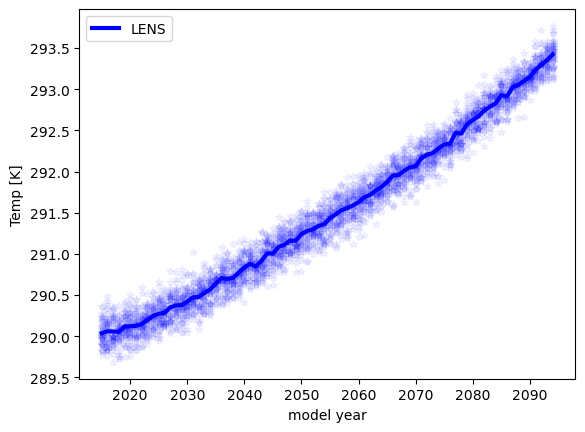

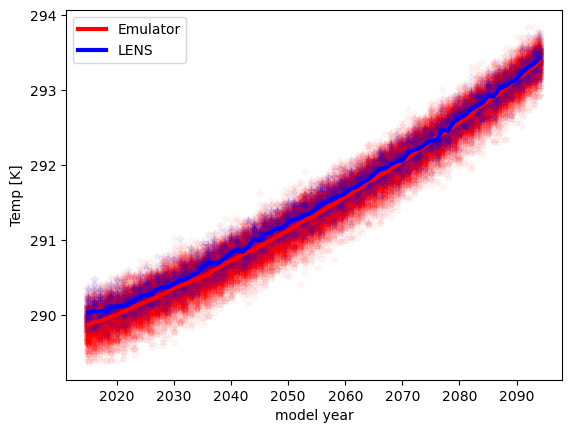

In [9]:
for bb in all_lens_mea_trend.keys():
    plt.plot([2015+bb]*50,all_lens_mea_trend[bb],'*', alpha =0.05,color='b')
plt.plot(np.arange(0,80)+2015,np.array(lens_mea_trend),'b',label='LENS',linewidth=3)
plt.legend()
plt.xlabel('model year')
plt.ylabel('Temp [K]')
plt.show()

for bb in all_mea_trend.keys():
    plt.plot([2015+bb]*500,all_mea_trend[bb],'*', alpha =0.03,color='r')

for bb in all_lens_mea_trend.keys():
    plt.plot([2015+bb]*50,all_lens_mea_trend[bb],'*', alpha =0.05,color='b')
    
plt.plot(np.arange(0,80)+2015,np.array(mea_trend),'r',label='Emulator',linewidth=3)
plt.plot(np.arange(0,80)+2015,np.array(lens_mea_trend),'b',label='LENS',linewidth=3)
plt.xlabel('model year')
plt.ylabel('Temp [K]')
plt.legend()
plt.show()

## How is the ENSO signal Changing?
- look at the LENS also

In [2]:
import xarray as xr

In [17]:
fn = '/users_home/training/data/Group_01/Ensembles//samples_governance_indexes_3944_month01_co20.0003989547760583052_001.nc'
DS1 = xr.open_dataset(fn)
slopes_diffy_early = compute_regression_slopes(DS1.sel(samples=slice(0,25)), vardo='TREFHT', region_lat=(-5, 5), region_lon=(190, 240))

#now lens: 
co2vmr = float(fn.split('co2')[-1].split('_')[0])
FNS = sorted(glob.glob('/users_home/training/data/Group_01/LENS/*1001.001*.nc'))
yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)
if mt != 2:
    print('NOOOOOO!--- an error has occurred')
FNS_year = sorted(glob.glob(f'/users_home/training/data/Group_01/LENS/*.{int(fout.split(".")[-2][:4])}*.nc'))
results_da1 = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)
results_da2 = extract_closest_co2vmr_data(co2vmr, mt, 'PRECT', FNS_year)
results_da3 = extract_closest_co2vmr_data(co2vmr, mt, 'PS', FNS_year)
results_da = xr.merge([results_da1,results_da2,results_da3])
slopes_diffy_lens_early = compute_regression_slopes(results_da.sel(time=slice(0,50)).rename({'time':'samples'}), vardo='TREFHT', region_lat=(-5, 5), region_lon=(190, 240))

fn = '/users_home/training/data/Group_01/Ensembles//samples_governance_indexes_3944_month01_co20.0008072813444974997_001.nc'
DS1 = xr.open_dataset(fn)
slopes_diffy_late = compute_regression_slopes(DS1.sel(samples=slice(0,500)), vardo='TREFHT', region_lat=(-5, 5), region_lon=(190, 240))

#now lens: 
co2vmr = float(fn.split('co2')[-1].split('_')[0])
FNS = sorted(glob.glob('/users_home/training/data/Group_01/LENS/*1001.001*.nc'))
yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)
if mt != 2:
    print('NOOOOOO!--- an error has occurred')
FNS_year = sorted(glob.glob(f'//users_home/training/data/Group_01/LENS/*.{int(fout.split(".")[-2][:4])}*.nc'))
results_da1 = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)
results_da2 = extract_closest_co2vmr_data(co2vmr, mt, 'PRECT', FNS_year)
results_da3 = extract_closest_co2vmr_data(co2vmr, mt, 'PS', FNS_year)
results_da = xr.merge([results_da1,results_da2,results_da3])
slopes_diffy_lens_late = compute_regression_slopes(results_da.sel(time=slice(0,50)).rename({'time':'samples'}), vardo='TREFHT', region_lat=(-5, 5), region_lon=(190, 240))

min dist: 0.0
min dist: 0.00037671090311000804
min dist: 0.0003378237836056529
min dist: 0.0002933643184194008
min dist: 0.0002436529146507382
min dist: 0.00018852645904463645
min dist: 0.00012749415895684738
min dist: 6.006114640949307e-05
min dist: 0.0


## Visualize it

Diffusion ENSO Early Years:


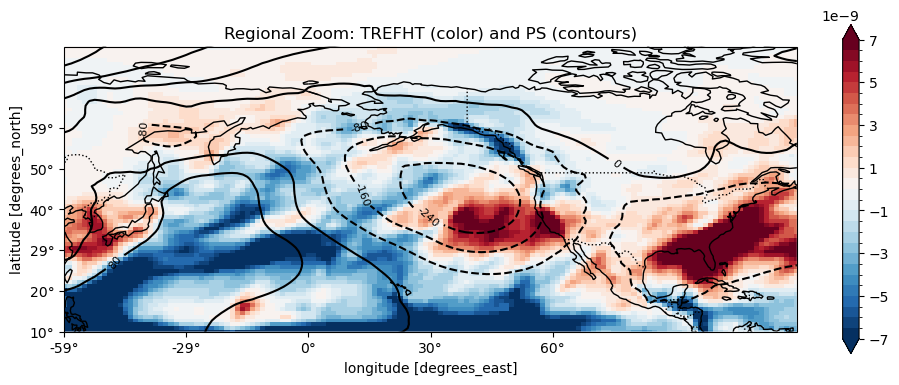

LENS ENSO Early Years:


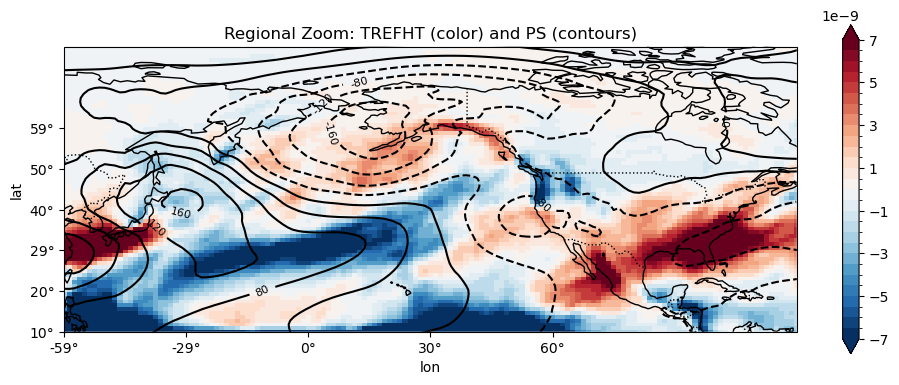

Diffusion ENSO Late Years:


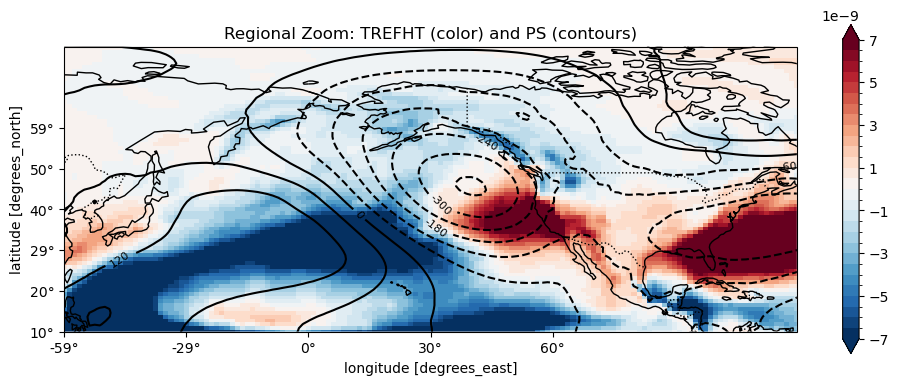

LENS ENSO Late Years:


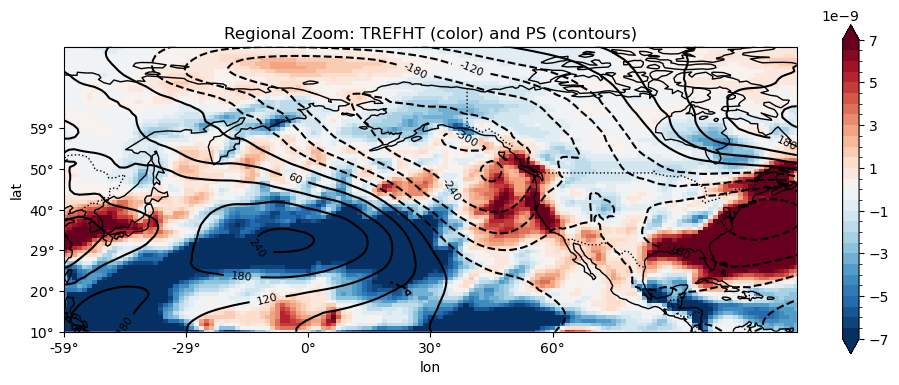

In [18]:
print('Diffusion ENSO Early Years:')
plot_ENSO_NA(slopes_diffy_early)
print('LENS ENSO Early Years:')
plot_ENSO_NA(slopes_diffy_lens_early)
print('Diffusion ENSO Late Years:')
plot_ENSO_NA(slopes_diffy_late)
print('LENS ENSO Late Years:')
plot_ENSO_NA(slopes_diffy_lens_late)

## The difference of these fields? 

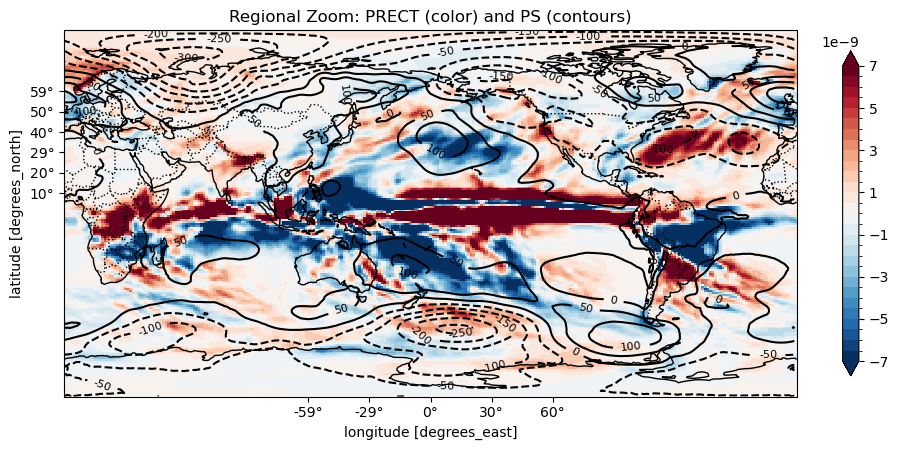

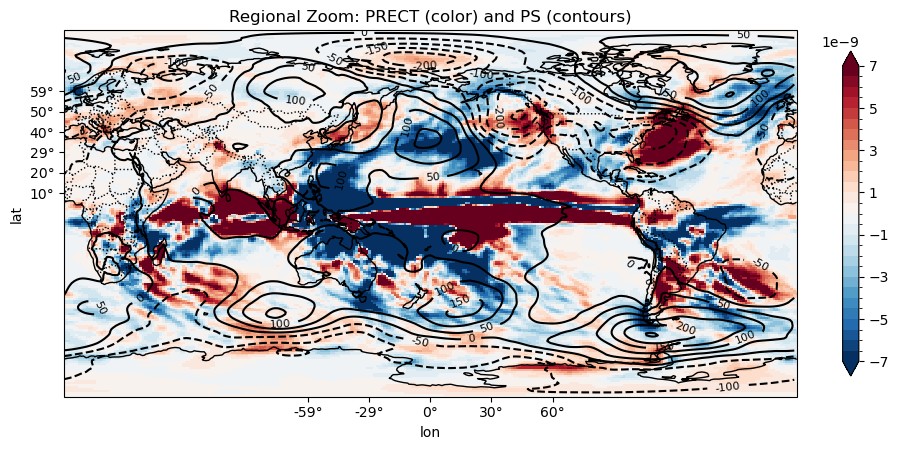

In [19]:
plot_ENSO_NA_diff(slopes_diffy_late, slopes_diffy_early)
plot_ENSO_NA_diff(slopes_diffy_lens_late, slopes_diffy_lens_early)

## EOFS?

In [13]:

##########################################################################
#select a diffusion file:
##########################################################################

fn = '//users_home/training/data/Group_01/Ensembles/samples_governance_indexes_3944_month02_co20.0003991389897498876_001.nc'
DS1 = xr.open_dataset(fn)

##########################################################################
#open the corresponding LENS file (Month and CO2).: 
##########################################################################
#now lens: 
#this forms the LENS dataset that corresponds to the DIFFUSION Month and CO2:
#this forms the LENS dataset that corresponds to the DIFFUSION Month and CO2:

co2vmr = float(fn.split('co2')[-1].split('_')[0])
FNS = sorted(glob.glob('/users_home/training/data/Group_01/LENS/*1001.001*.nc'))
yt, mt, fout = closest_co2vmr_year(co2vmr, FNS)
if mt != 3:
    print('NOOOOOO!--- an error has occurred')
FNS_year = sorted(glob.glob(f'/users_home/training/data/Group_01/LENS/*.{int(fout.split(".")[-2][:4])}*.nc'))
#this forms the LENS dataset:
results_da1 = extract_closest_co2vmr_data(co2vmr, mt, 'TREFHT', FNS_year)
results_da2 = extract_closest_co2vmr_data(co2vmr, mt, 'PRECT', FNS_year)
results_da3 = extract_closest_co2vmr_data(co2vmr, mt, 'PS', FNS_year)
results_da = xr.merge([results_da1,results_da2,results_da3])

#above forms the LENS dataset that corresponds to the DIFFUSION Month and CO2:
#above forms the LENS dataset that corresponds to the DIFFUSION Month and CO2:
##########################################################################
##########################################################################


min dist: 0.0


/tmp/ipykernel_181197/1994131375.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


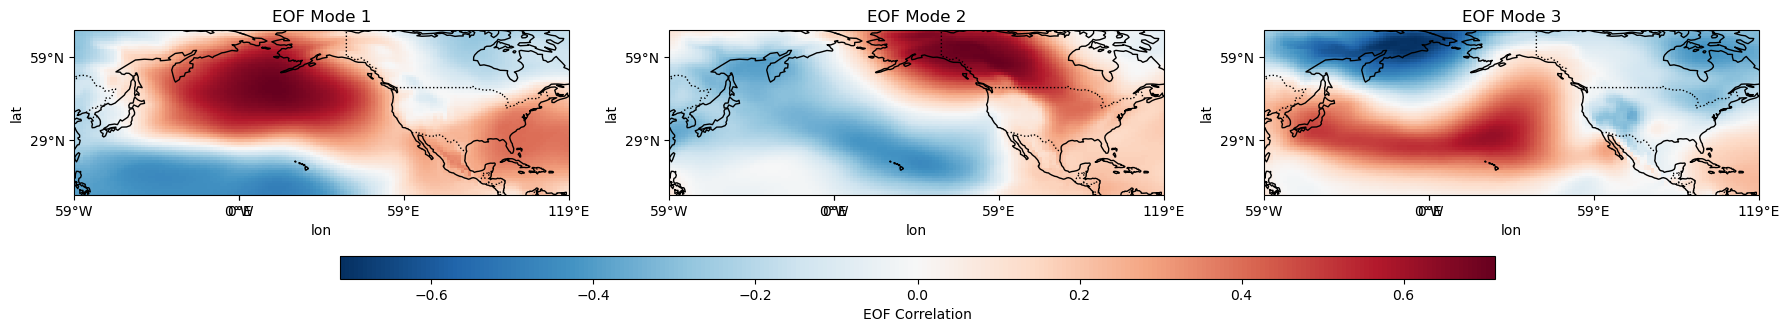

/tmp/ipykernel_181197/1994131375.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


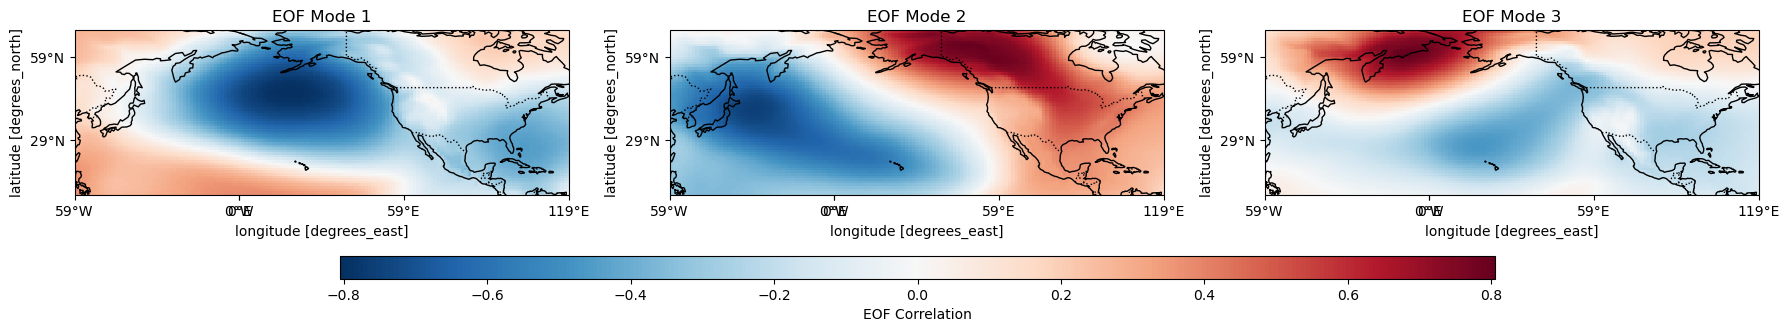

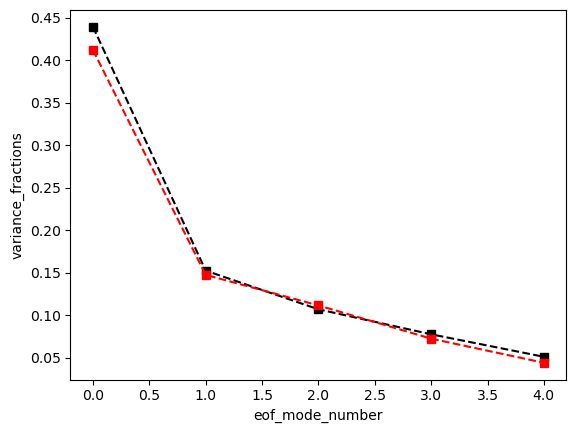

In [16]:
# Assuming PS is already calculated from the dataset DS_lens
PS = DS1['PS'].sel(lat=slice(0, 70), lon=slice(120, 300))
PS = PS.rename({'samples': 'time'})

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Perform EOF analysis
solver2 = Eof(PS, weights=wgts)
eof2 = solver2.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc2 = solver2.pcs(npcs=3, pcscaling=1)

# Assuming PS is already calculated from the dataset DS_lens
PS = results_da['PS'].sel(lat=slice(0, 70), lon=slice(120, 300))

# Calculate weights based on cosine of latitude
coslat = np.cos(np.deg2rad(PS.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]

# Perform EOF analysis
solver1 = Eof(PS, weights=wgts)
eof1 = solver1.eofsAsCorrelation(neofs=3)  # Get the first 3 EOFs
pc1 = solver1.pcs(npcs=3, pcscaling=1)

# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = eof1.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())


# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

# Create a figure with three subplots for the first three EOF modes
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Define longitude and latitude ticks (global)
lon_ticks = np.arange(-180, 181, 60)
lat_ticks = np.arange(-90, 91, 30)
extent = [120, 300, 10, 70]  # [min_lon, max_lon, min_lat, max_lat]

# Define common properties for all subplots
for i in range(3):
    eof_mode = -1*eof2.sel(mode=i).squeeze()
    ax = axs[i]

    # Plot each EOF mode
    plot = eof_mode.plot(
        ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='RdBu_r', 
        add_colorbar=False  # We will add a single colorbar later
    )

    # Set titles for each mode
    ax.set_title(f'EOF Mode {i+1}')

    # Add coastlines and borders
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Set longitude and latitude ticks
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())

    # Format tick labels
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else (f'{int(abs(x))}°W' if x < 0 else f'{int(x)}°')))
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else (f'{int(abs(y))}°S' if y < 0 else f'{int(y)}°')))
    ax.set_extent(extent, crs=ccrs.PlateCarree())


# Add a single colorbar for all subplots
cbar = fig.colorbar(plot, ax=axs, orientation='horizontal', fraction=0.05, pad=0.04, aspect=50)
cbar.set_label('EOF Correlation')

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom of the figure to fit the colorbar nicely
plt.show()

solver1.varianceFraction(neigs=5).plot(color='k',linestyle='--',marker='s')
solver2.varianceFraction(neigs=5).plot(color='r',linestyle='--',marker='s')
plt.show()